In [ ]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import os
import sys
from typing import Dict, Any
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)
from src.optimization.milp_schedulerv7 import build_and_solve_schedule_v7
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120


/home/mak/Documents/Optimization/Project


In [2]:

fields_path   = "../../data/processed/illinois_corn_fields_clean.csv"
weekly_master_path  = "../../data/processed/master_weekly_table_2017_2024.csv"
TMP_FOLDER   = "../../data/processed/mc_v7/"
OUTPUT_CSV   = "../../data/processed/monte_carlo_results_v7.csv"

os.makedirs(TMP_FOLDER, exist_ok=True)

# Slightly reduced machine capacity (more realistic)
base_params = {
    "base_planter_capacity": 700.0,   # ≈ 300–450 ac/day realistic
    "base_harvester_capacity": 450.0, # ≈ 100–180 ac/day realistic
    "labor_plant_per_acre": 0.25,
    "labor_harvest_per_acre": 0.35,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 10.0,
    "statewide_corn_acres": 12_000_000,
    "time_limit": 150,
}




In [4]:
def run_monte_carlo_v7(
    fields_path,
    weekly_master_path,
    sims=30,
    target_year=2017
):
    results = []
    rng = np.random.default_rng(42)

    for i in range(sims):
        wm = pd.read_csv(weekly_master_path)
        wm_year = wm[wm["year"] == target_year].copy()

        # 🚀 Stronger v8 shocks
        wm_year["prcp_week_in"] *= rng.uniform(0.7, 2.5)
        wm_year["TAVG"] += rng.normal(0, 8)
        wm_year["AWND"] *= rng.uniform(0.6, 1.5)
        wm_year["labor_hours"] *= rng.uniform(0.75, 1.25)

        temp_path = f"/tmp/mc_v8_{i}.csv"
        temp_path = f"{TMP_FOLDER}/mc_v7_{i}.csv"
        wm_year.to_csv(temp_path, index=False)

        df = build_and_solve_schedule_v7(
            fields_path, temp_path, target_year=target_year,
            time_limit=200
        )
        df["sim"] = i
        results.append(df)

    return pd.concat(results, ignore_index=True)


In [5]:
df_all = run_monte_carlo_v7(fields_path, weekly_master_path, sims=100)
# df_sim = run_all_visualizations(df_all)


Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 200
Set parameter Presolve to value 1
Set parameter Threads to value 4
Set parameter Heuristics to value 0.1
Set parameter MIPFocus to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Non-default parameters:
TimeLimit  200
Heuristics  0.1
MIPFocus  1
Presolve  1
Threads  4

Optimize a model with 387 rows, 976 columns and 3600 nonzeros (Min)
Model fingerprint: 0x53fd8b81
Model has 76 linear objective coefficients
Variable types: 201 continuous, 775 integer (775 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e-04, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 211 rows and 436 columns
Preso

In [42]:
df_all.to_csv("../../data/processed/monte_carlo_results_v7.csv", index=False)

# Visualization

In [ ]:
def compute_safe_percentiles(series, percentiles=[50, 75, 90, 95, 99]):
    """
    Computes percentiles safely:
    - ignores NaN
    - returns None if the array is empty
    - returns a dict of percentile → value
    """
    # Remove NaN
    arr = series.dropna().values

    if len(arr) == 0:
        # no data → return None for each percentile
        return {p: None for p in percentiles}

    # Compute percentiles
    return {p: float(np.percentile(arr, p)) for p in percentiles}
# makespan_pct = compute_safe_percentiles(df_all["makespan"])
# print("Percentiles:")
# for p, v in makespan_pct.items():
#     print(f"{p}th %tile = {v} weeks")



In [ ]:
def summarize_simulation_results(df_all):
    """
    df_all = Monte Carlo output (one row per field per sim)
    Returns: df_sim (one row per simulation)
    """
    sim_groups = df_all.groupby("sim")

    df_sim = sim_groups.agg({
        "makespan": "max",
        "total_penalty": "sum",
        "late_penalty": "sum",
        "early_penalty": "sum",
        "frost_penalty": "sum",
    }).reset_index()

    # Count late harvest fields
    df_sim["late_harvests"] = sim_groups.apply(
        lambda g: (g["status"] == "LATE").sum()
    ).values

    # Extract frost week per simulation
    df_sim["frost_week"] = sim_groups.apply(
        lambda g: g["harvest_week"].max()
    ).values

    # Feasibility flag
    df_sim["feasible"] = df_sim["makespan"].notnull()

    return df_sim


In [7]:
def print_best_worst(df_sim, k=10):
    print("\n======== BEST {} SCENARIOS ========\n".format(k))
    print(df_sim.nsmallest(k, "makespan")[["sim","makespan","total_penalty","late_harvests","frost_week"]])

    print("\n======== WORST {} SCENARIOS ========\n".format(k))
    print(df_sim.nlargest(k, "makespan")[["sim","makespan","total_penalty","late_harvests","frost_week"]])


In [8]:
def plot_makespan_distribution(df_sim):
    plt.figure(figsize=(10,6))
    sns.histplot(df_sim["makespan"], bins=15, kde=True, color="#64B5F6")
    plt.xlabel("Makespan (weeks)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Makespan (Feasible Scenarios)")
    plt.show()


In [9]:
def plot_penalty_distribution(df_sim):
    plt.figure(figsize=(10,6))
    sns.histplot(df_sim["total_penalty"], bins=15, kde=True, color="#EF9A9A")
    plt.xlabel("Penalty Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Total Penalties")
    plt.show()


In [10]:
def plot_late_harvest_counts(df_sim):
    plt.figure(figsize=(8,5))
    sns.countplot(x=df_sim["late_harvests"], color="green")
    plt.title("Late Harvest Counts Across Feasible Scenarios")
    plt.xlabel("Late Fields")
    plt.ylabel("Count")
    plt.show()


In [25]:
def plot_makespan_cdf(df_sim):
    sorted_ms = np.sort(df_sim["makespan"])
    cdf = np.arange(1, len(sorted_ms)+1) / len(sorted_ms)

    plt.figure(figsize=(10,6))
    plt.plot(sorted_ms, cdf, marker="o")
    plt.xlabel("Makespan (weeks)")
    plt.ylabel("Cumulative Probability")
    plt.title("Risk Curve — Makespan CDF")
    plt.grid(True, alpha=0.4)
    plt.show()

    makespan_pct = compute_safe_percentiles(df_all["makespan"])
    print("Percentiles:")
    for p, v in makespan_pct.items():
        print(f"{p}th %tile = {v} weeks")


In [12]:
def plot_frost_vs_makespan(df_sim):
    plt.figure(figsize=(10,6))
    plt.scatter(df_sim["frost_week"], df_sim["makespan"], s=80)
    plt.xlabel("Latest Harvest Week (Frost Proxy)")
    plt.ylabel("Makespan (weeks)")
    plt.title("Impact of Frost Week on Makespan")
    plt.grid(True, alpha=0.3)
    plt.show()


In [13]:
def plot_late_vs_makespan(df_sim):
    plt.figure(figsize=(10,6))
    plt.scatter(df_sim["late_harvests"], df_sim["makespan"], s=80)
    plt.xlabel("Late Harvest Fields")
    plt.ylabel("Makespan (weeks)")
    plt.title("Relationship Between Late Harvests & Makespan")
    plt.grid(True, alpha=0.3)
    plt.show()


In [14]:
def plot_penalty_vs_makespan(df_sim):
    plt.figure(figsize=(10,6))
    plt.scatter(df_sim["total_penalty"], df_sim["makespan"], s=80, color="maroon")
    plt.xlabel("Penalty Score")
    plt.ylabel("Makespan (weeks)")
    plt.title("Penalty vs Makespan")
    plt.grid(True, alpha=0.3)
    plt.show()


In [15]:
def plot_correlation_heatmap(df_sim):
    metrics = ["makespan", "total_penalty", "late_harvests", "frost_week"]
    corr = df_sim[metrics].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Correlation Heatmap — Monte Carlo v7")
    plt.show()


In [16]:
def plot_feasibility(df_sim):
    feasible = df_sim["feasible"].sum()
    infeasible = len(df_sim) - feasible

    plt.figure(figsize=(6,6))
    plt.pie(
        [feasible, infeasible],
        labels=["Feasible", "Infeasible"],
        autopct="%.1f%%",
        colors=["#4CAF50", "#D32F2F"]
    )
    plt.title("Feasibility Breakdown (Monte Carlo v7)")
    plt.show()


In [17]:
def run_all_visualizations(df_all):
    df_sim = summarize_simulation_results(df_all)

    plot_feasibility(df_sim)
    print_best_worst(df_sim)

    plot_makespan_distribution(df_sim)
    plot_penalty_distribution(df_sim)

    plot_late_harvest_counts(df_sim)
    plot_makespan_cdf(df_sim)

    plot_frost_vs_makespan(df_sim)
    plot_late_vs_makespan(df_sim)
    plot_penalty_vs_makespan(df_sim)

    plot_correlation_heatmap(df_sim)

    return df_sim


/tmp/ipykernel_41612/1207013872.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sim["late_harvests"] = sim_groups.apply(
/tmp/ipykernel_41612/1207013872.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sim["frost_week"] = sim_groups.apply(


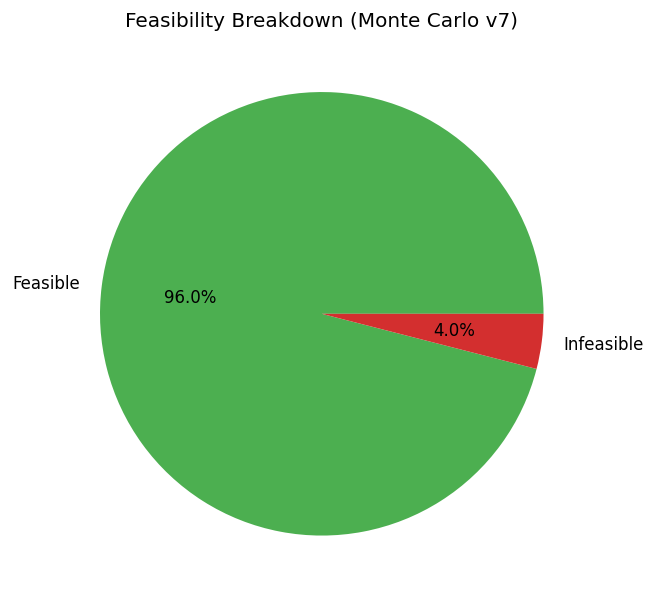


======== BEST 10 SCENARIOS ========

    sim  makespan  total_penalty  late_harvests  frost_week
1     1      40.0            0.0              0        40.0
18   18      40.0            0.0              0        40.0
59   59      40.0            0.0              0        40.0
0     0      42.0            1.0              0        42.0
2     2      42.0            0.0              0        42.0
4     4      42.0            0.0              0        42.0
7     7      42.0            0.0              0        42.0
8     8      42.0            0.0              0        42.0
9     9      42.0            0.0              0        42.0
10   10      42.0            0.0              0        42.0

======== WORST 10 SCENARIOS ========

    sim  makespan  total_penalty  late_harvests  frost_week
75   75      50.0      20.000000              0        50.0
47   47      47.0       5.000000              0        47.0
72   72      45.0       2.000000              0        45.0
3     3      44.0      

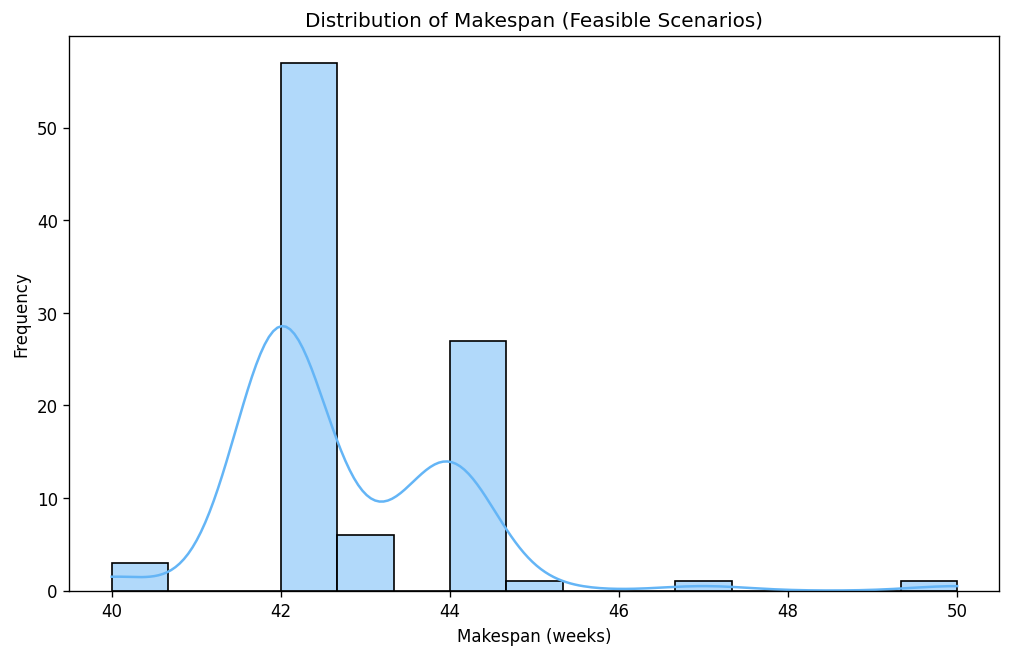

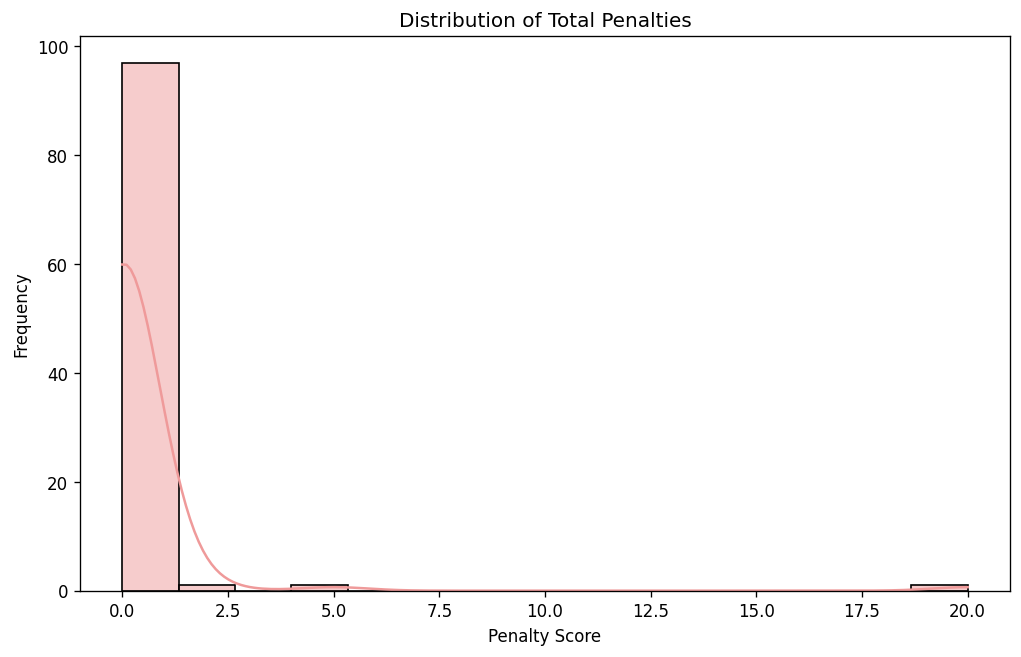

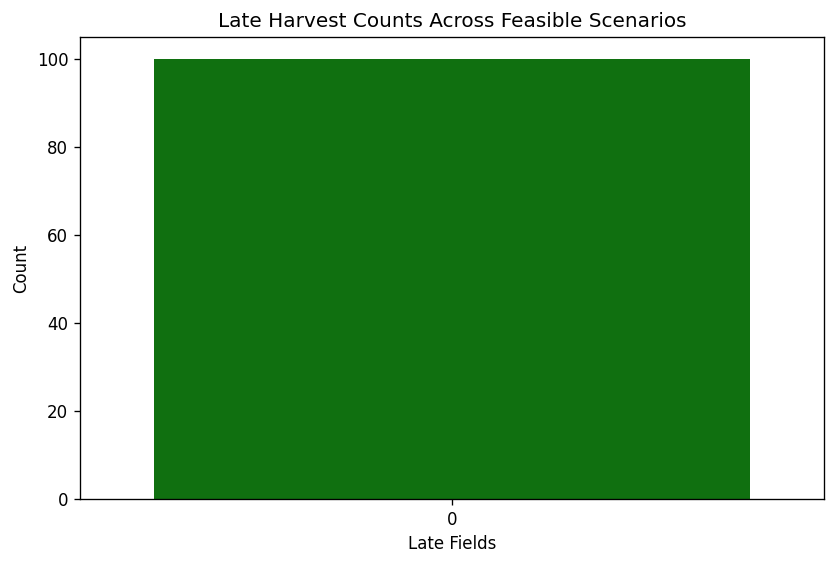

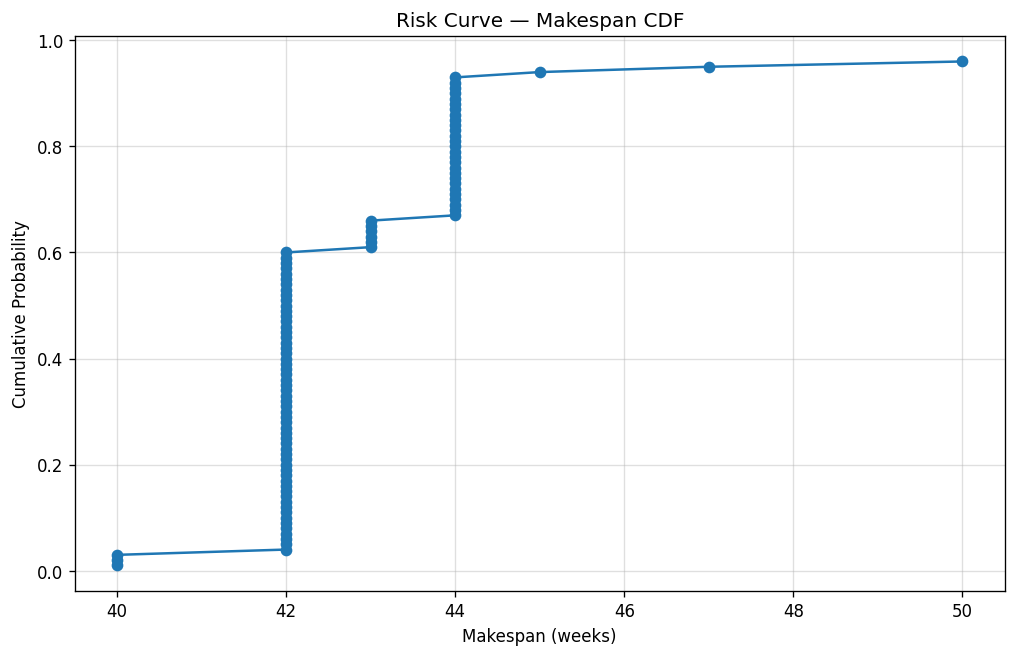

Percentiles:
50th %tile = 42.0 weeks
75th %tile = 44.0 weeks
90th %tile = 44.0 weeks
95th %tile = 44.0 weeks
99th %tile = 50.0 weeks


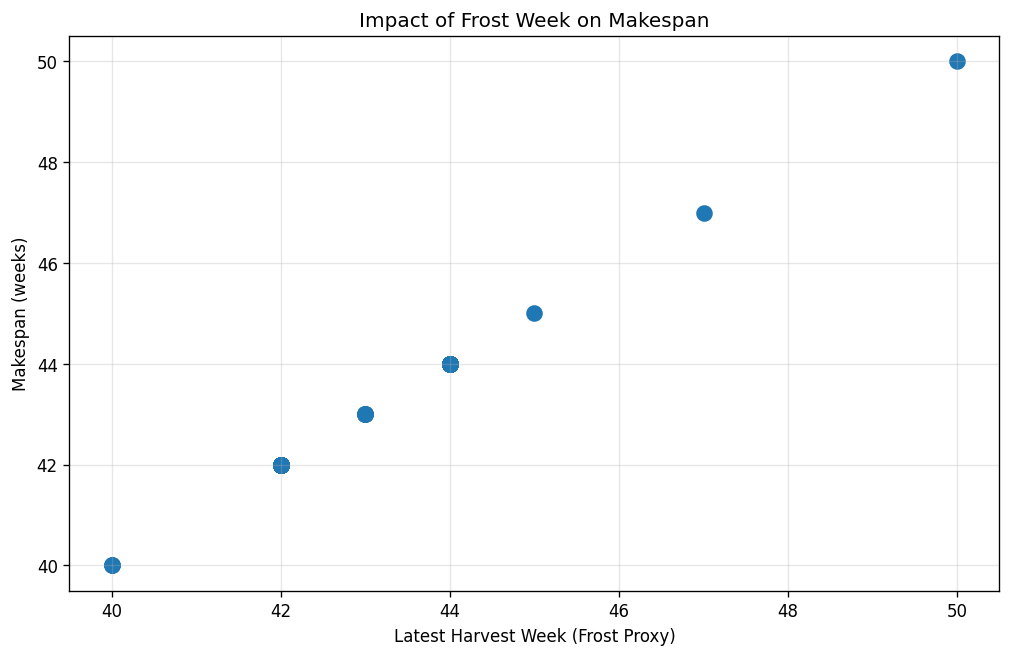

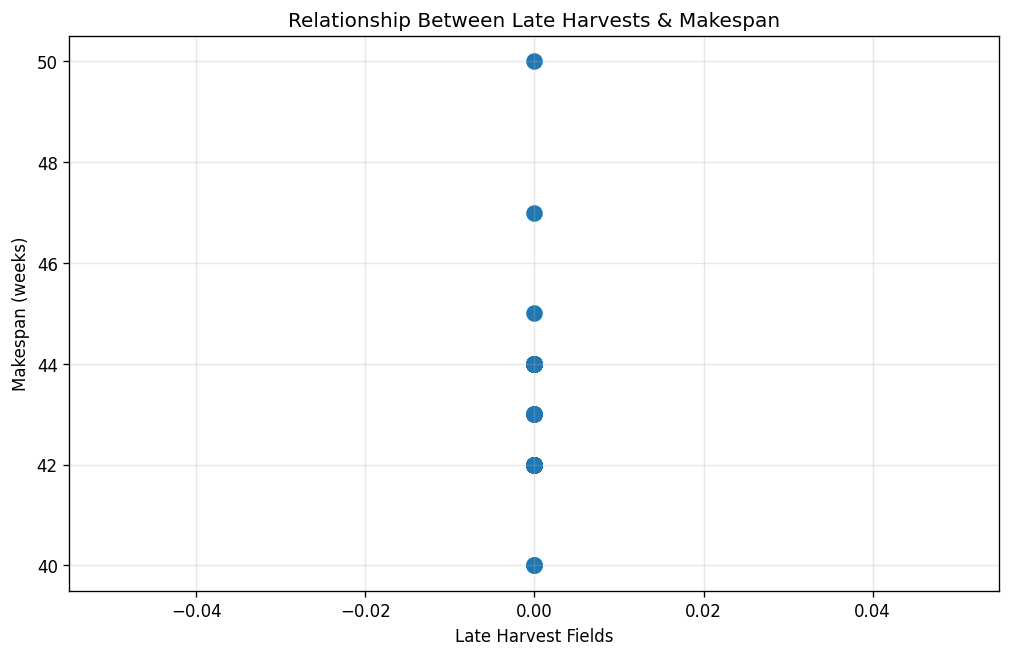

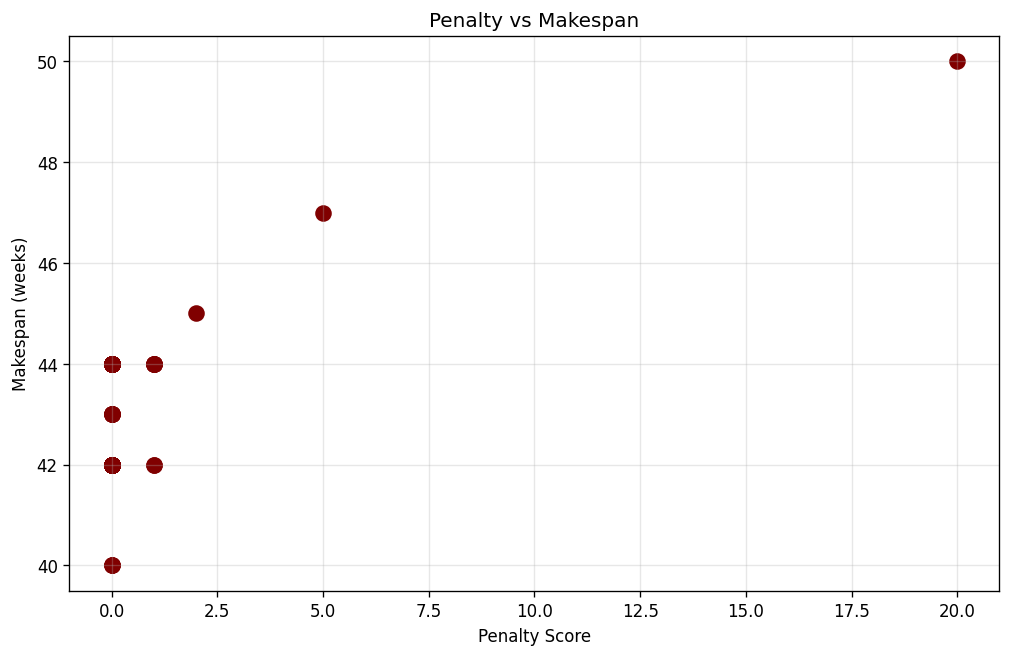

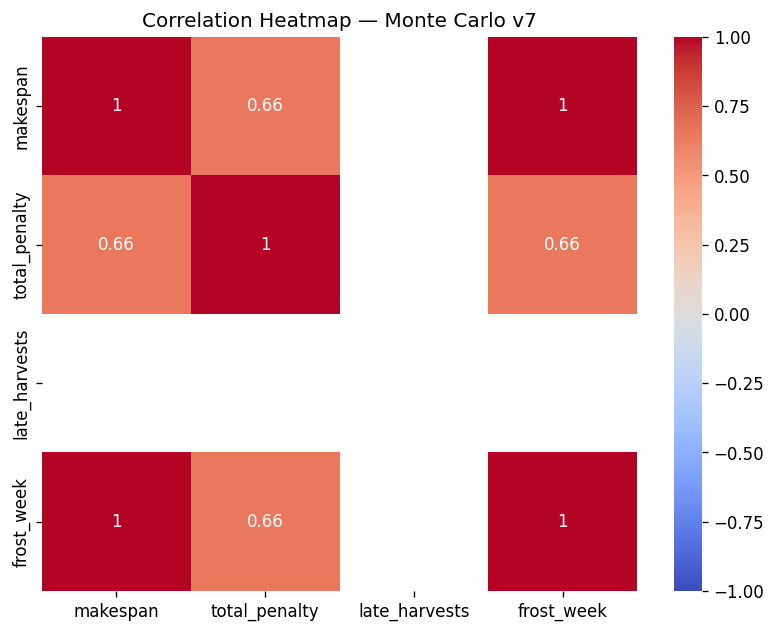

,sim,makespan,total_penalty,late_penalty,early_penalty,frost_penalty,late_harvests,frost_week,feasible
0,0,42.0,1.0,0.0,1.0,0.0,0,42.0,True
1,1,40.0,0.0,0.0,0.0,0.0,0,40.0,True
2,2,42.0,0.0,0.0,0.0,0.0,0,42.0,True
3,3,44.0,0.0,0.0,0.0,0.0,0,44.0,True
4,4,42.0,0.0,0.0,0.0,0.0,0,42.0,True
...,...,...,...,...,...,...,...,...,...
95,95,44.0,0.0,0.0,0.0,0.0,0,44.0,True
96,96,44.0,0.0,0.0,0.0,0.0,0,44.0,True
97,97,42.0,0.0,0.0,0.0,0.0,0,42.0,True
98,98,42.0,0.0,0.0,0.0,0.0,0,42.0,True


In [26]:
run_all_visualizations(df_all)

In [30]:
df_all[df_all.status == "FROST_RISK"]

,field_id,plant_week,harvest_week,early_penalty,late_penalty,frost_penalty,total_penalty,status,makespan,sim,error
1142,F016,19.0,47.0,0.0,0.0,3.0,3.0,FROST_RISK,47.0,47,NaN
1145,F019,16.0,45.0,0.0,0.0,1.0,1.0,FROST_RISK,47.0,47,NaN
1720,F017,21.0,45.0,0.0,0.0,1.0,1.0,FROST_RISK,45.0,72,NaN
1779,F001,16.0,45.0,0.0,0.0,1.0,1.0,FROST_RISK,50.0,75,NaN
1780,F002,16.0,50.0,0.0,0.0,6.0,6.0,FROST_RISK,50.0,75,NaN
1783,F005,16.0,49.0,0.0,0.0,5.0,5.0,FROST_RISK,50.0,75,NaN
1784,F006,15.0,48.0,0.0,0.0,4.0,4.0,FROST_RISK,50.0,75,NaN
1796,F018,19.0,47.0,0.0,0.0,3.0,3.0,FROST_RISK,50.0,75,NaN


In [33]:
def plot_frost_frequency(df_all):
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = df_all.copy()

    df['is_frost'] = df['status'] == "FROST_RISK"

    frost_rate = df.groupby("sim")['is_frost'].max()

    plt.figure(figsize=(8,5))
    sns.barplot(x=['No Frost', 'Frost/Late'], 
                y=[1 - frost_rate.mean(), frost_rate.mean()],
                palette=['green','red'])
    
    plt.title("Frequency of Frost Risk Across Simulations")
    plt.ylabel("Proportion of Simulations")
    plt.ylim(0,1)
    plt.show()


/tmp/ipykernel_41612/807064903.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['No Frost', 'Frost/Late'],


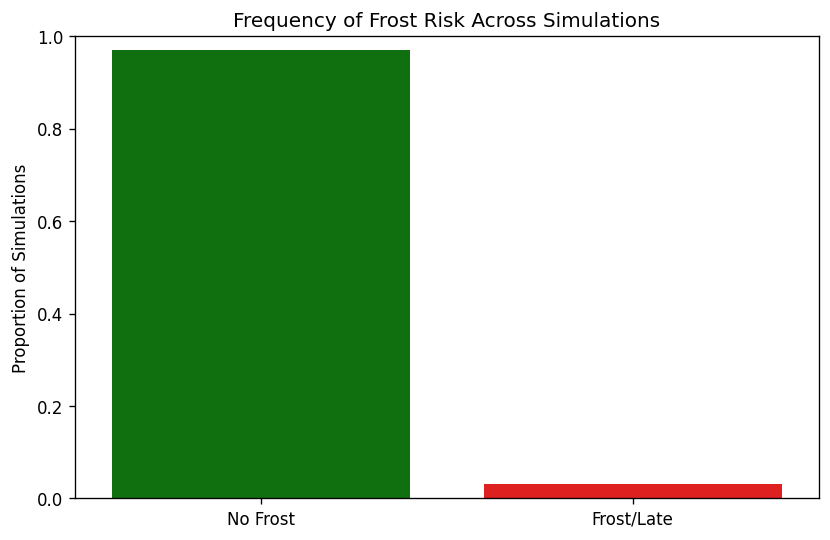

In [34]:
plot_frost_frequency(df_all)

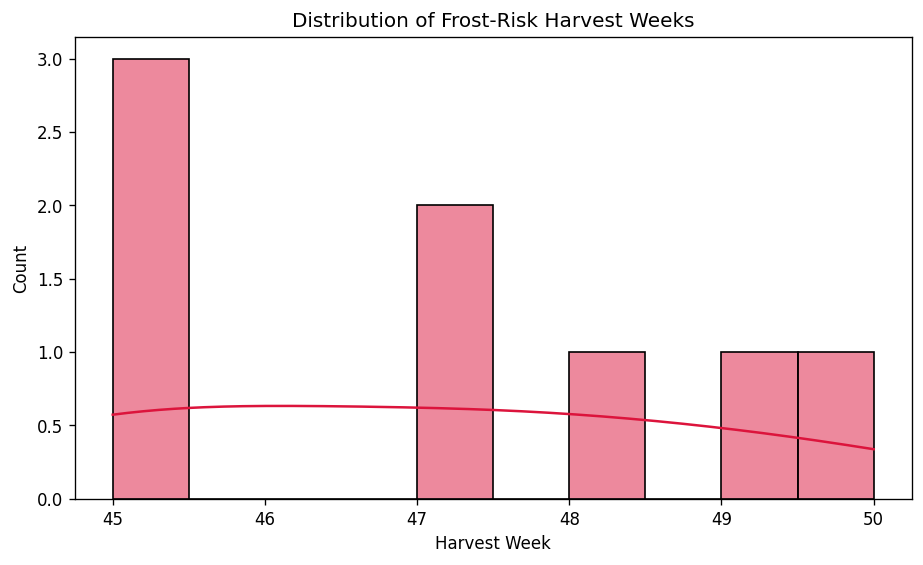

In [35]:
def plot_frost_week_distribution(df_all):
    import matplotlib.pyplot as plt
    import seaborn as sns

    frost_df = df_all[df_all['status'] == "FROST_RISK"]

    plt.figure(figsize=(9,5))
    sns.histplot(frost_df['harvest_week'], bins=10, kde=True, color='crimson')
    
    plt.title("Distribution of Frost-Risk Harvest Weeks")
    plt.xlabel("Harvest Week")
    plt.ylabel("Count")
    plt.show()
plot_frost_week_distribution(df_all)

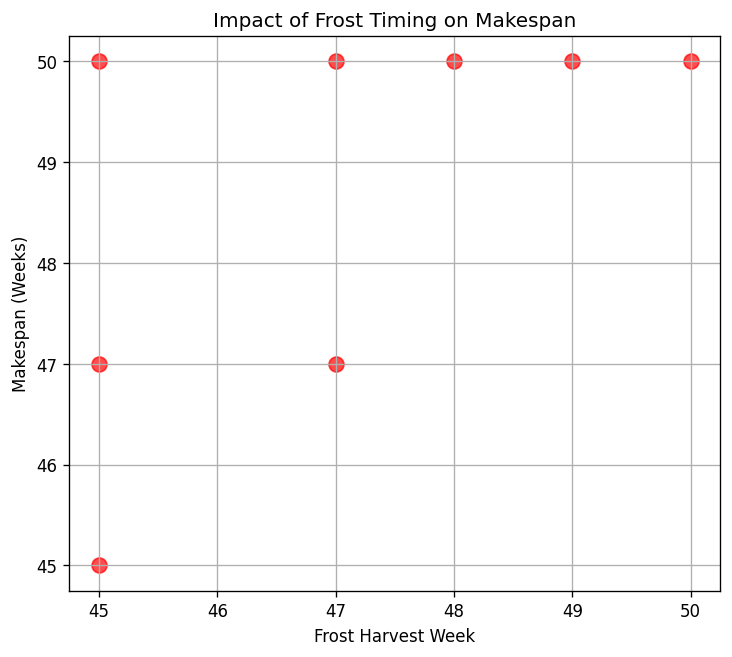

In [37]:
def plot_frost_vs_makespan(df_all):
    import matplotlib.pyplot as plt

    frost_df = df_all[df_all['status'] == "FROST_RISK"]

    plt.figure(figsize=(7,6))
    plt.scatter(frost_df['harvest_week'], frost_df['makespan'], 
                color='red', alpha=0.7, s=80)
    
    plt.xlabel("Frost Harvest Week")
    plt.ylabel("Makespan (Weeks)")
    plt.title("Impact of Frost Timing on Makespan")
    plt.grid(True)
    plt.show()
plot_frost_vs_makespan(df_all)

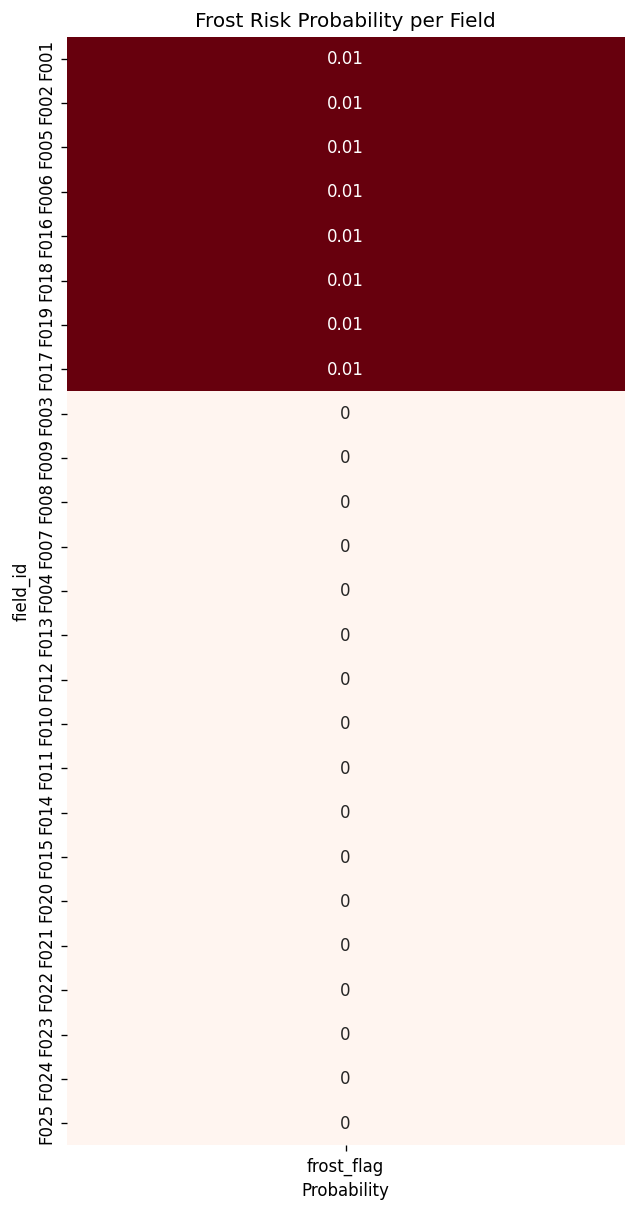

In [40]:
def plot_frost_heatmap(df_all):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    frost_df = df_all.copy()
    frost_df['frost_flag'] = frost_df['status'] == "FROST_RISK"

    pivot = frost_df.pivot_table(
        index='field_id', 
        values='frost_flag',
        aggfunc='mean'
    ).sort_values('frost_flag', ascending=False)

    plt.figure(figsize=(6,12))
    sns.heatmap(pivot, annot=True, cmap="Reds", cbar=False)
    plt.title("Frost Risk Probability per Field")
    plt.xlabel("Probability")
    plt.show()
plot_frost_heatmap(df_all)

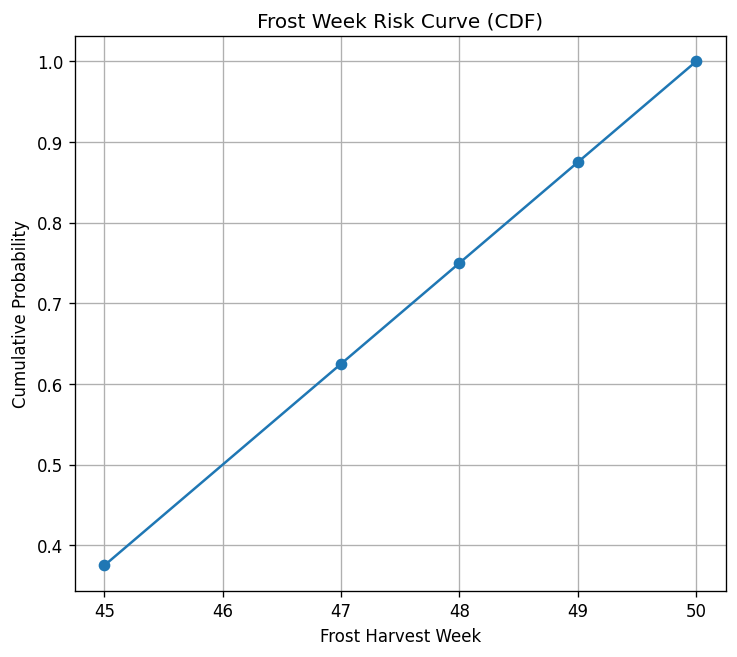

In [41]:
def plot_frost_cdf(df_all):
    import numpy as np
    import matplotlib.pyplot as plt

    frost_df = df_all[df_all['status'] == "FROST_RISK"]

    w = np.sort(frost_df['harvest_week'].unique())
    p = np.array([(frost_df['harvest_week'] <= x).mean() for x in w])

    plt.figure(figsize=(7,6))
    plt.plot(w, p, marker='o')
    plt.xlabel("Frost Harvest Week")
    plt.ylabel("Cumulative Probability")
    plt.title("Frost Week Risk Curve (CDF)")
    plt.grid(True)
    plt.show()
plot_frost_cdf(df_all)